# CNN
This workbook is part of the waste image classification project.

This workbook explores the viability of Convolutional Neural Networks for waste image classification.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard
from azureml.core.environment import Environment

from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook and setup for this set of experiments.

In [2]:
# Load the stored workspace
ws = Workspace.from_config()

In [3]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [4]:
# get the registered env
env = Environment.get(ws, 'waste-env-gpu')

In [5]:
# get our compoute cluster
# for cnn we will use a gpu cluster
compute_name = "gpu-cluster2-NC6"
compute_target = ws.compute_targets[compute_name]

In [6]:
# set the expiriment
experiment_name = 'cnn'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [7]:
script_path = 'cnn_train_script/'

if not os.path.exists(script_path):
    os.mkdir(script_path)

# move the utils.py to the upload dir
shutil.copy('utils.py', script_path)


'cnn_train_script/utils.py'

In [8]:
%%writefile cnn_train_script/train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, 
                                                  img_to_array,
                                                  load_img)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')


parser.add_argument('--conv_nodes', 
                    type=str, 
                    dest='conv_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--conv_kernel_sizes', 
                    type=str, 
                    dest='conv_kernel_sizes', 
                    default='32', 
                    help='kernel_size for each convolution layer (comma separated)')
parser.add_argument('--conv_activations', 
                    type=str, 
                    dest='conv_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')
parser.add_argument('--pool_sizes', 
                    type=str, 
                    dest='pool_sizes', 
                    default='(2,2)', 
                    help='pool size for max pooling layer (comma separated)')

    
parser.add_argument('--dense_nodes', 
                    type=str, 
                    dest='dense_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--dense_activations', 
                    type=str, 
                    dest='dense_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')

parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
conv_nodes = [int(x) for x in args.conv_nodes.split(',')]
conv_kernel_sizes = args.conv_kernel_sizes[1:-1].split('],[')
conv_kernel_sizes = [(int(x.split(',')[0]),int(x.split(',')[0])) for x in conv_kernel_sizes]
conv_activations = args.conv_activations.split(',')
pool_sizes = args.pool_sizes[1:-1].split('],[')
pool_sizes = [(int(x.split(',')[0]),int(x.split(',')[0])) for x in pool_sizes]

dense_nodes = args.dense_nodes.split(',')
dense_activations = args.dense_activations.split(',')

# get azure run context
run = Run.get_context()

# print to log for debuggig if necessary
print('Data folder:',args.data_path)

print('Convolution Nodes:', conv_nodes)
for node in conv_nodes:
    print(type(node))

print('Convolution kernel_sizes:', conv_kernel_sizes)
for node in conv_kernel_sizes:
    print(type(node))

print('ConvolutionActivations:', conv_activations)
for node in conv_activations:
    print(type(node))

print('Pool Sizes', pool_sizes)
for node in pool_sizes:
    print(type(node))
    
print('Dense Nodes:', dense_nodes)
print('Dense Activations:', dense_activations)

# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             #target_size = (244, 244),
                                             batch_size = 32)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             #target_size = (244, 244),
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             #target_size = (244, 244),
                                             batch_size = num_test)

# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]

# Build the model
model = models.Sequential()

# Add Convolution 2D layers
for node, kernel_size, activation, pool_size in zip(conv_nodes, 
                                         conv_kernel_sizes, 
                                         conv_activations,
                                         pool_sizes):
    print(f'Creating Conv2D layer with {node} nodes,',
          f'kernel_size={kernel_size} and activation={activation}')
    model.add(layers.Conv2D(node, kernel_size, activation=activation))
    print(f'Creating MaxPooling2d layer with pool_size={pool_size}')
    model.add(layers.MaxPooling2D(pool_size))

# Flatten layer for subsequent Dense layers
model.add(layers.Flatten())

# create Dense layers based on parameters
for node, activation in zip(dense_nodes, dense_activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=args.epochs,
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_generator)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting cnn_train_script/train.py


## Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [9]:
# create var to stor run objects
runs = []

### Model 1 - Baseline
Layers
1. Convolution, 32 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Convolution, 64 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Dense 64 nodes, sigmoid activation function
- optimizer: sgd

In [10]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [11]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'conv32-64dense64'})

runs[-1].tag('class', 'cnn')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '3')
runs[-1].tag('convolution layers', '2')
runs[-1].tag('dense layers', '1')

### Start Tensorboard to monitor the runs

In [12]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [13]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [17]:
log = log_runs(runs, 'cnn')
log

{'test_loss': 1.2125370502471924, 'test_accuracy': 0.524193525314331}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615982333_e6957587,conv32-64dense64,cnn,00:07:34.003002,1.212537,0.524194,"[1.6840869188308716, 1.5897852182388306, 1.521...","[0.29137325286865234, 0.3622359037399292, 0.38...","[1.643269419670105, 1.5500829219818115, 1.4121...","[0.25954198837280273, 0.3358778655529022, 0.47..."


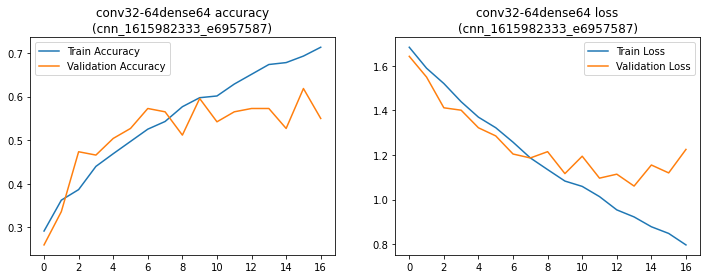

In [18]:
# visualize train/validation accuracy and loss
visualize_log(log)

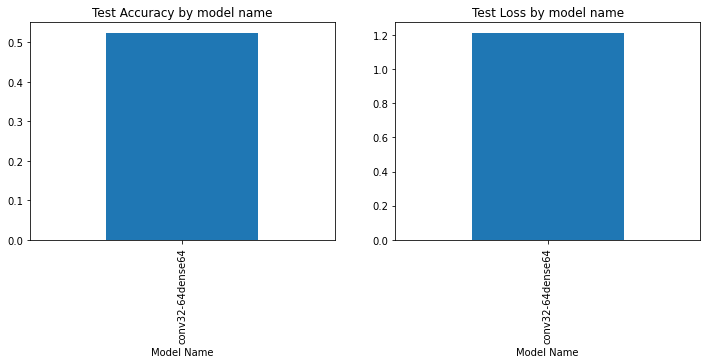

In [19]:
# plot test accuracy
plot_accuracy(log)

This base run performed better than the MLP runs in the previous notebook.

# Test 1
In this test I will experiment with different sizes for the convolution layers.

In [20]:
runs2 = []

### Model 2 

Layers
1. Convolution, 64 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Convolution, 128 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Dense 64 nodes, sigmoid activation function
- optimizer: sgd

In [21]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '64,128',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [22]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'conv64-128dense64'})

runs2[-1].tag('class', 'cnn')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '3')
runs2[-1].tag('convolution layers', '2')
runs2[-1].tag('dense layers', '1')

### Model 3
Layers
1. Convolution, 128 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Convolution, 256 nodes, activation relu
1. MaxPooling2d, kernel_size=(2,2)
1. Dense 64 nodes, sigmoid activation function
- optimizer: sgd

In [23]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '128,256',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [24]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'conv128-256dense256'})

runs2[-1].tag('class', 'cnn')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '3')
runs2[-1].tag('convolution layers', '2')
runs2[-1].tag('dense layers', '1')

# Start Tensorboard to monitor runs

In [25]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs2)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [26]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [27]:
# log the results
log = log_runs(runs2, 'cnn')
log

{'test_loss': 1.1690222024917603, 'test_accuracy': 0.5887096524238586}

{'test_loss': 1.1929377317428589, 'test_accuracy': 0.5564516186714172}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615982333_e6957587,conv32-64dense64,cnn,00:07:34.003002,1.212537,0.524194,"[1.6840869188308716, 1.5897852182388306, 1.521...","[0.29137325286865234, 0.3622359037399292, 0.38...","[1.643269419670105, 1.5500829219818115, 1.4121...","[0.25954198837280273, 0.3358778655529022, 0.47..."
cnn_1615983834_627eae55,conv64-128dense64,cnn,00:11:49.586034,1.169022,0.588710,"[1.7542558908462524, 1.6818784475326538, 1.644...","[0.22843310236930847, 0.24295774102210999, 0.3...","[1.6844849586486816, 1.647598385810852, 1.5704...","[0.23664122819900513, 0.25190839171409607, 0.3..."
cnn_1615983840_b5637cf9,conv128-256dense256,cnn,00:22:26.401587,1.192938,0.556452,"[1.7459113597869873, 1.7062486410140991, 1.663...","[0.23415492475032806, 0.23679576814174652, 0.2...","[1.7055063247680664, 1.6787775754928589, 1.608...","[0.23664122819900513, 0.23664122819900513, 0.3..."


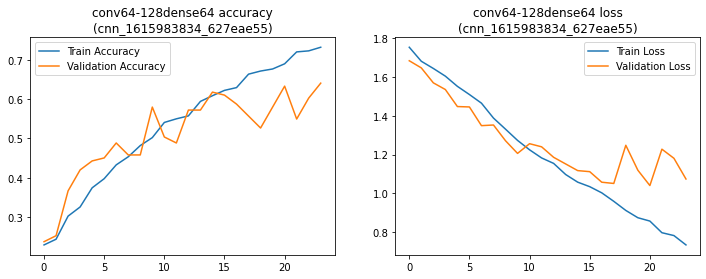

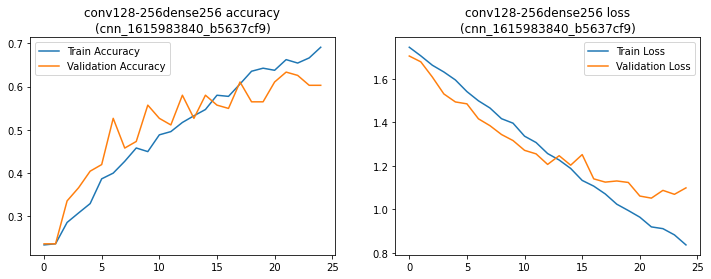

In [28]:
# visualize train vs validation accuracy and loss
visualize_log(log.loc[[r.id for r in runs2]])

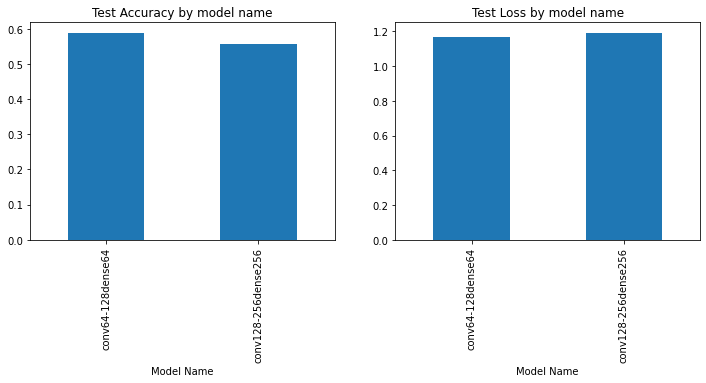

In [29]:
# look at test accuracy and loss
plot_accuracy(log.loc[[r.id for r in runs2]])

The highest testing accuracy came from our model with 64 nodes in the first convolution layer and 128 in the second.  It also achieved that accuracy in fewer epochs than the 128/256 model.

# Test 2
Add more convolutional layers to our best performing model so far

In [30]:
runs3=[]

### Model 4
- Convolution Layer 1 nodes: 32
- Convolution Layer 2 nodes: 64
- Convolution Layer 2 nodes: 128
- optimizer: sgd

In [31]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64,128',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [32]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'conv32-64-128-dense64'})

runs3[-1].tag('class', 'cnn')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '4')
runs3[-1].tag('convolution layers', '3')
runs3[-1].tag('dense layers', '1')

### Model 5
- Convolution Layer 1 nodes: 64
- Convolution Layer 2 nodes: 128
- Convolution Layer 2 nodes: 256
- optimizer: sgd

In [33]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '64,128,256',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [34]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'conv64-128-256-dense64'})

runs3[-1].tag('class', 'cnn')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '4')
runs3[-1].tag('convolution layers', '3')
runs3[-1].tag('dense layers', '1')

# Start Tensorboard to monitor runs

In [35]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs3)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [36]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [37]:
log = log_runs(runs3, 'cnn')
log

{'test_loss': 1.1293892860412598, 'test_accuracy': 0.5564516186714172}

{'test_loss': 1.1351020336151123, 'test_accuracy': 0.6290322542190552}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615982333_e6957587,conv32-64dense64,cnn,00:07:34.003002,1.212537,0.524194,"[1.6840869188308716, 1.5897852182388306, 1.521...","[0.29137325286865234, 0.3622359037399292, 0.38...","[1.643269419670105, 1.5500829219818115, 1.4121...","[0.25954198837280273, 0.3358778655529022, 0.47..."
cnn_1615983834_627eae55,conv64-128dense64,cnn,00:11:49.586034,1.169022,0.588710,"[1.7542558908462524, 1.6818784475326538, 1.644...","[0.22843310236930847, 0.24295774102210999, 0.3...","[1.6844849586486816, 1.647598385810852, 1.5704...","[0.23664122819900513, 0.25190839171409607, 0.3..."
cnn_1615983840_b5637cf9,conv128-256dense256,cnn,00:22:26.401587,1.192938,0.556452,"[1.7459113597869873, 1.7062486410140991, 1.663...","[0.23415492475032806, 0.23679576814174652, 0.2...","[1.7055063247680664, 1.6787775754928589, 1.608...","[0.23664122819900513, 0.23664122819900513, 0.3..."
cnn_1615987210_49b498bf,conv32-64-128-dense64,cnn,00:07:45.503681,1.129389,0.556452,"[1.7278008460998535, 1.6987640857696533, 1.672...","[0.22095070779323578, 0.25, 0.2772887349128723...","[1.6959342956542969, 1.6797510385513306, 1.611...","[0.23664122819900513, 0.20610687136650085, 0.2..."
cnn_1615987217_c42d5cb1,conv64-128-256-dense64,cnn,00:11:00.682834,1.135102,0.629032,"[1.71329665184021, 1.6383081674575806, 1.58281...","[0.24295774102210999, 0.3147006928920746, 0.34...","[1.6528847217559814, 1.5263153314590454, 1.508...","[0.28244274854660034, 0.4351145029067993, 0.35..."


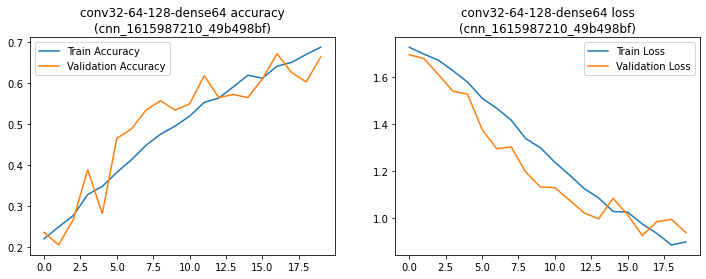

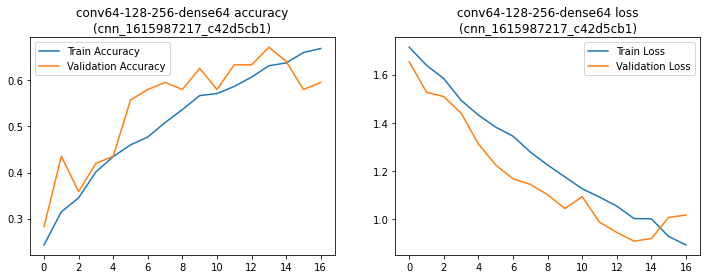

In [38]:
visualize_log(log.loc[[r.id for r in runs3]])

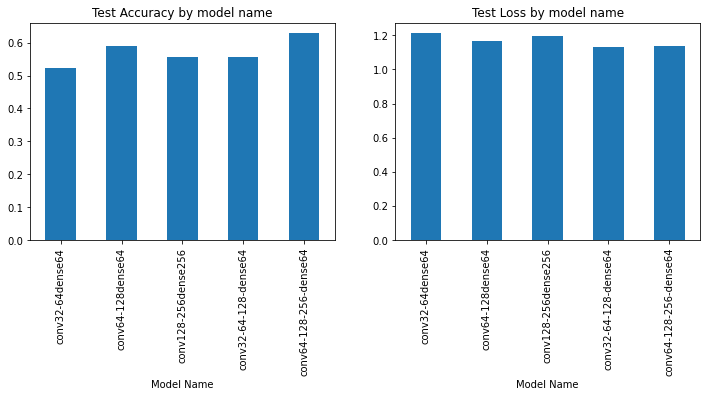

In [39]:
plot_accuracy(log)

The model with 3 convolution layers containing 64/128/256 nodes respectively was the best performer.

# Test 3
Increase the size of the dense layer at the end of the model

In [44]:
runs4=[]

### Model 6
- Convolution Layer 1 nodes: 32
- Convolution Layer 2 nodes: 64
- Convolution Layer 2 nodes: 128
- Dense nodes: 512
- optimizer: sgd

In [45]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64,128',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '512',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [46]:
runs4.append(exp.submit(config=src))

# Add name and tags for tracking
runs4[-1].add_properties({'name': 'conv32-64-128-dense512'})

runs4[-1].tag('class', 'cnn')
runs4[-1].tag('activation', 'relu')
runs4[-1].tag('optimizer', 'sgd')
runs4[-1].tag('convolution layers', '3')
runs4[-1].tag('dense layers', '1')

### Model 7
- Convolution Layer 1 nodes: 32
- Convolution Layer 2 nodes: 64
- Convolution Layer 2 nodes: 128
- Dense nodes: 1024
- optimizer: sgd

In [47]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64,128',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '1024',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [48]:
runs4.append(exp.submit(config=src))

# Add name and tags for tracking
runs4[-1].add_properties({'name': 'conv32-64-128-dense1024'})

runs4[-1].tag('class', 'cnn')
runs4[-1].tag('activation', 'relu')
runs4[-1].tag('optimizer', 'sgd')
runs4[-1].tag('convolution layers', '3')
runs4[-1].tag('dense layers', '1')

#### Model 7
- Convolution Layer 1 nodes: 32
- Convolution Layer 2 nodes: 64
- Convolution Layer 2 nodes: 128
- Dense nodes: 4096
- optimizer: sgd

In [49]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64,128',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '4096',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [50]:
runs4.append(exp.submit(config=src))

# Add name and tags for tracking
runs4[-1].add_properties({'name': 'conv32-64-128-dense4096'})

runs4[-1].tag('class', 'cnn')
runs4[-1].tag('activation', 'relu')
runs4[-1].tag('optimizer', 'sgd')
runs4[-1].tag('convolution layers', '3')
runs4[-1].tag('dense layers', '1')

# Start Tensorboard to monitor runs

In [51]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs4)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [52]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [56]:
log = log_runs(runs4, 'cnn')
log

{'test_loss': 1.0559688806533813, 'test_accuracy': 0.6290322542190552}

{'test_loss': 1.226462721824646, 'test_accuracy': 0.5403226017951965}

{'test_loss': 1.0142501592636108, 'test_accuracy': 0.6451612710952759}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615982333_e6957587,conv32-64dense64,cnn,00:07:34.003002,1.212537,0.524194,"[1.6840869188308716, 1.5897852182388306, 1.521...","[0.29137325286865234, 0.3622359037399292, 0.38...","[1.643269419670105, 1.5500829219818115, 1.4121...","[0.25954198837280273, 0.3358778655529022, 0.47..."
cnn_1615983834_627eae55,conv64-128dense64,cnn,00:11:49.586034,1.169022,0.588710,"[1.7542558908462524, 1.6818784475326538, 1.644...","[0.22843310236930847, 0.24295774102210999, 0.3...","[1.6844849586486816, 1.647598385810852, 1.5704...","[0.23664122819900513, 0.25190839171409607, 0.3..."
cnn_1615983840_b5637cf9,conv128-256dense256,cnn,00:22:26.401587,1.192938,0.556452,"[1.7459113597869873, 1.7062486410140991, 1.663...","[0.23415492475032806, 0.23679576814174652, 0.2...","[1.7055063247680664, 1.6787775754928589, 1.608...","[0.23664122819900513, 0.23664122819900513, 0.3..."
cnn_1615987210_49b498bf,conv32-64-128-dense64,cnn,00:07:45.503681,1.129389,0.556452,"[1.7278008460998535, 1.6987640857696533, 1.672...","[0.22095070779323578, 0.25, 0.2772887349128723...","[1.6959342956542969, 1.6797510385513306, 1.611...","[0.23664122819900513, 0.20610687136650085, 0.2..."
cnn_1615987217_c42d5cb1,conv64-128-256-dense64,cnn,00:11:00.682834,1.135102,0.629032,"[1.71329665184021, 1.6383081674575806, 1.58281...","[0.24295774102210999, 0.3147006928920746, 0.34...","[1.6528847217559814, 1.5263153314590454, 1.508...","[0.28244274854660034, 0.4351145029067993, 0.35..."
cnn_1615990699_f93b7756,conv32-64-128-dense512,cnn,00:08:37.887281,1.055969,0.629032,"[1.6957265138626099, 1.5942068099975586, 1.525...","[0.2649647891521454, 0.35783451795578003, 0.38...","[1.5904549360275269, 1.4574010372161865, 1.378...","[0.2748091518878937, 0.3893129825592041, 0.526..."
cnn_1615990705_9d86843f,conv32-64-128-dense1024,cnn,00:08:21.123221,1.226463,0.540323,"[1.692376732826233, 1.6041311025619507, 1.5393...","[0.2632042169570923, 0.34639084339141846, 0.37...","[1.620043396949768, 1.4938374757766724, 1.3544...","[0.4351145029067993, 0.38167938590049744, 0.45..."
cnn_1615990711_bd2354e6,conv32-64-128-dense4096,cnn,00:26:35.104986,1.014250,0.645161,"[1.683275818824768, 1.5874526500701904, 1.5018...","[0.27420774102211, 0.35387325286865234, 0.3974...","[1.6335582733154297, 1.462890386581421, 1.3415...","[0.3664122223854065, 0.4351145029067993, 0.526..."


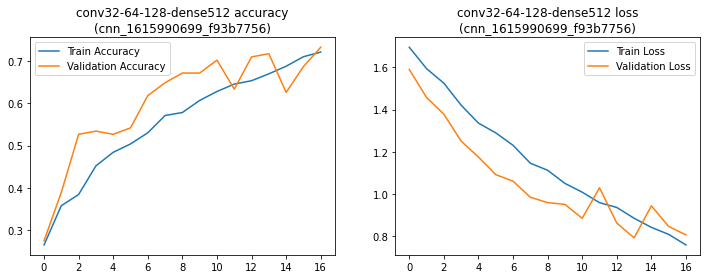

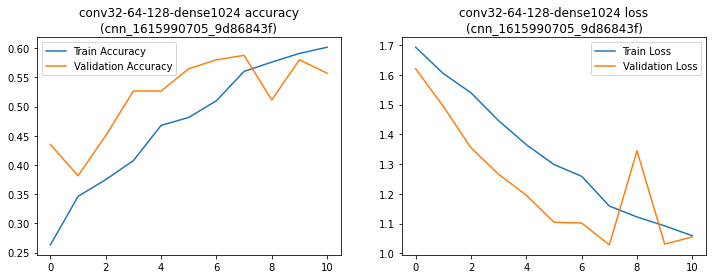

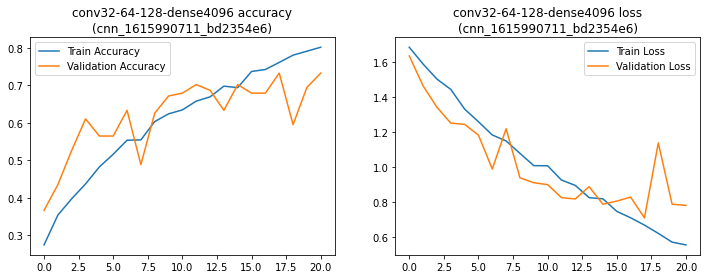

In [57]:
visualize_log(log.loc[[r.id for r in runs4]])

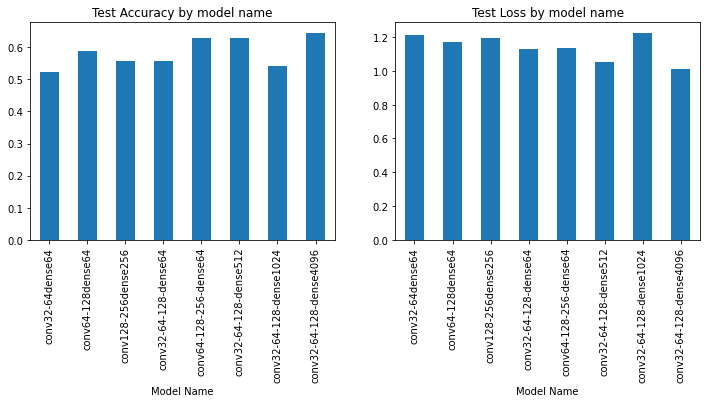

In [58]:
plot_accuracy(log)

The best CNN model we tried had 3 convolution with 64, 128, and 256 layers respectively and one dense layer with 4096 nodes.  The test accuracy was still only 64.5%.  Next up, transfer learning with the pre-trained [VGG16 model](4_VGG16_Azure.ipynb)